In [1]:
!pip install transformers

In [2]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW as TransformersAdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [3]:
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [4]:
# Load the CSV file into a DataFrame
file_path = 'https://raw.githubusercontent.com/Letieateat/Sentiment-Analysis-on-Traditional-Chinese-Lyrics/main/dataset/final_sentiments.csv'
df = pd.read_csv(file_path)

# Select only the three specific columns
df = df[['final_lyrics', 'human_2']]

In [5]:
label_map =  {'Negative': 0, 'Positive': 1}
df['labels'] = df['human_2'].map(label_map)
df.rename(columns={'final_lyrics': 'Input'}, inplace=True)

In [6]:
# Prepare datasets
train, temp = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Load model & tokenizer
tokenizer = BertTokenizerFast.from_pretrained('ckiplab/bert-base-chinese')
config = BertConfig.from_pretrained('ckiplab/bert-base-chinese', num_labels=len(label_map), hidden_dropout_prob=0.3)
model = BertForSequenceClassification.from_pretrained('ckiplab/bert-base-chinese', config=config)

train_dataset = LyricsDataset(train['Input'].tolist(), train['labels'].tolist(), tokenizer)
val_dataset = LyricsDataset(val['Input'].tolist(), val['labels'].tolist(), tokenizer)
test_dataset = LyricsDataset(test['Input'].tolist(), test['labels'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Training and finding the best learning rate

In [7]:
# Check the availability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

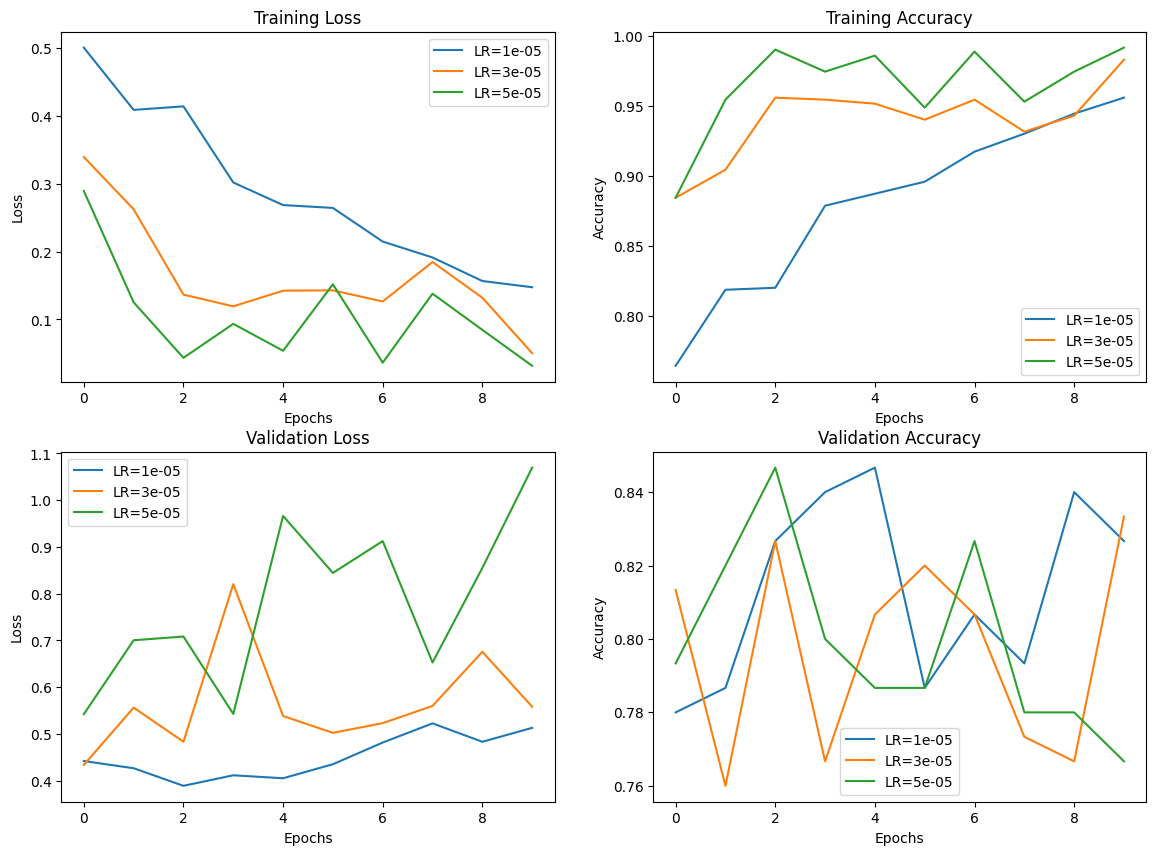

In [9]:
learning_rates = [1e-5, 3e-5, 5e-5]
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

for lr in learning_rates:
    optimizer = Adam(model.parameters(), lr=lr, eps=1e-8)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(10):
        model.train()
        total_train_loss = 0
        correct_train_predictions = 0
        total_train_samples = 0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = CrossEntropyLoss()(outputs.logits, batch['labels'])
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_train_predictions += (predictions == batch['labels']).sum().item()
            total_train_samples += len(batch['labels'])

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_val_loss = 0
        correct_val_predictions = 0
        total_val_samples = 0
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                loss = CrossEntropyLoss()(outputs.logits, batch['labels'])
                total_val_loss += loss.item()
                predictions = torch.argmax(outputs.logits, dim=1)
                correct_val_predictions += (predictions == batch['labels']).sum().item()
                total_val_samples += len(batch['labels'])

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(avg_val_loss)

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    # Plotting the results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, lr in enumerate(learning_rates):
    axes[0, 0].plot(all_train_losses[i], label=f"LR={lr}")
    axes[0, 1].plot(all_train_accuracies[i], label=f"LR={lr}")
    axes[1, 0].plot(all_val_losses[i], label=f"LR={lr}")
    axes[1, 1].plot(all_val_accuracies[i], label=f"LR={lr}")

axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.show()